In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
from tess_sip import SIP
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}

In [12]:
srs_tpfs = lk.search_targetpixelfile("WASP50", author="TESS-SPOC")
tpfs = srs_tpfs.download_all()
srs_tpfs

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
1,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


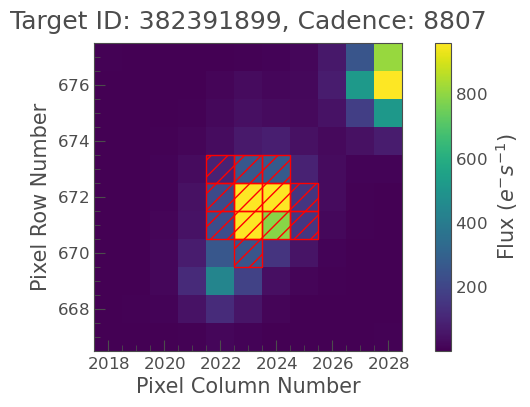

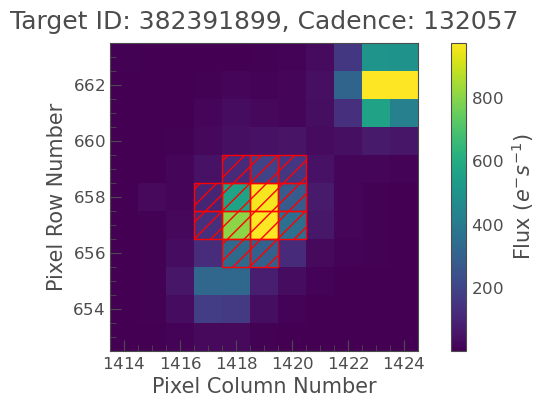

In [13]:
for tpf in tpfs:
    tpf.plot(aperture_mask="pipeline")
    plt.show()

In [14]:
srs_lcs = lk.search_lightcurve("WASP50", author="TESS-SPOC")
lcs = srs_lcs.download_all()
srs_lcs

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
1,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


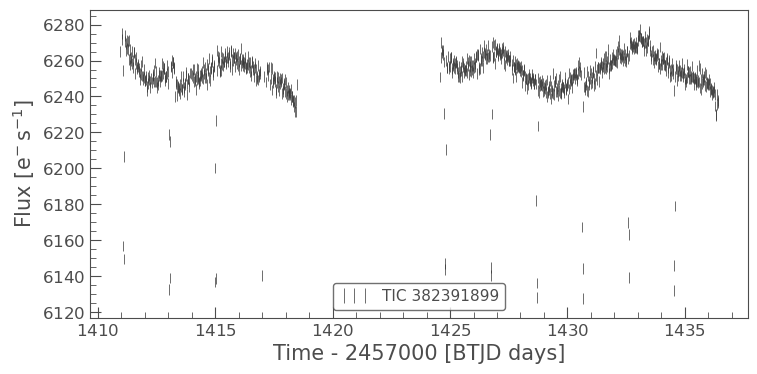

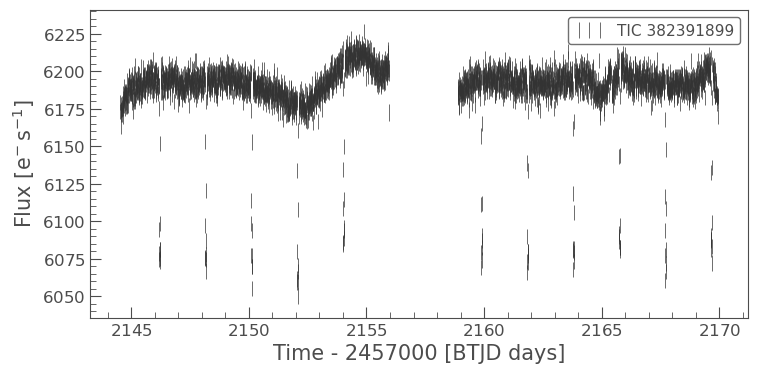

In [15]:
for lc in lcs:
    lc.errorbar()
    plt.show()

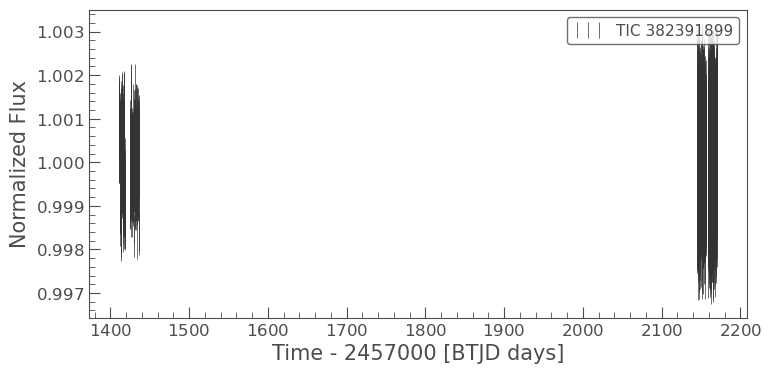

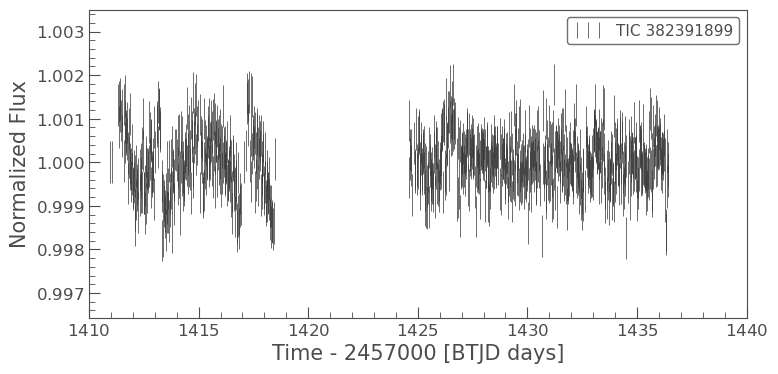

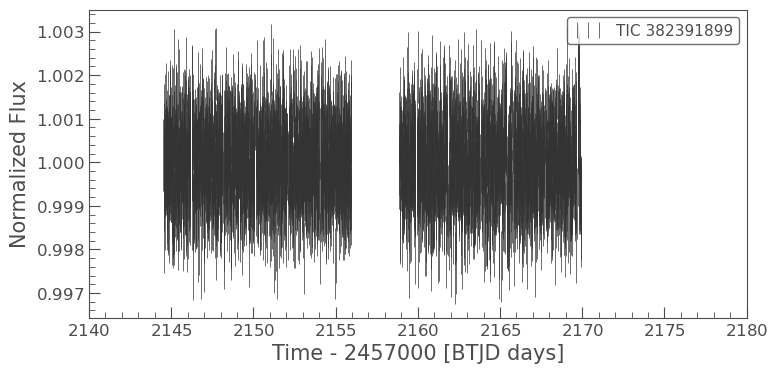

In [71]:
lc_combined = lcs.stitch(lambda x: x.remove_nans().flatten().remove_outliers(sigma=3.0).normalize())

ax = lc_combined.errorbar()
plt.show()

ax = lc_combined.errorbar()
ax.set_xlim(1_410, 1_440)
plt.show()

ax = lc_combined.errorbar()
ax.set_xlim(2_140, 2_180)
plt.show()

In [124]:
r["raw_lc"]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1410.953531534125,9.6415532e-01,3.5758974e-04,5.0713364e-03,8807,2023.38262,671.63832,5.5566040e+03,2.5508912e+00,1.3212648e+03,9.3030214e-01,6.2650864e+03,2.9836752e+00,0,nan,nan,nan,nan,2023.38262,3.5472744e-04,671.63832,3.4198278e-04,1.7395616e-01,-6.5861329e-02
1411.0160328776744,9.6393263e-01,3.5759693e-04,5.0727054e-03,8810,2023.38274,671.63938,5.5559033e+03,2.5509424e+00,1.3203771e+03,9.2924196e-01,6.2714932e+03,2.9837356e+00,1000000000,nan,nan,nan,nan,2023.38274,3.5507735e-04,671.63938,3.4230645e-04,1.7488852e-01,-6.5621160e-02
1411.0368666555985,9.6403313e-01,3.5770360e-04,5.0731585e-03,8811,2023.38283,671.63876,5.5555483e+03,2.5517035e+00,1.3214486e+03,9.3088424e-01,6.2752153e+03,2.9846256e+00,0,nan,nan,nan,nan,2023.38283,3.5496557e-04,671.63876,3.4266122e-04,1.7486960e-01,-6.6337854e-02
1411.057700431659,9.6129483e-01,3.5715543e-04,5.0736098e-03,8812,2023.38295,671.63885,5.5355669e+03,2.5477929e+00,1.3218965e+03,9.3013680e-01,6.2544976e+03,2.9800515e+00,0,nan,nan,nan,nan,2023.38295,3.5582905e-04,671.63885,3.4357168e-04,1.7546071e-01,-6.5822899e-02
1411.0785342058568,9.4973713e-01,3.5541024e-04,5.0740591e-03,8813,2023.38260,671.64020,5.4549209e+03,2.5353436e+00,1.3200946e+03,9.2980236e-01,6.1569521e+03,2.9654901e+00,0,nan,nan,nan,nan,2023.38260,3.5937849e-04,671.64020,3.4687915e-04,1.7522457e-01,-6.4440161e-02
1411.099367978658,9.4914889e-01,3.5531496e-04,5.0745071e-03,8814,2023.38285,671.63816,5.4502383e+03,2.5346639e+00,1.3205808e+03,9.2918813e-01,6.1497158e+03,2.9646950e+00,0,nan,nan,nan,nan,2023.38285,3.5964852e-04,671.63816,3.4697348e-04,1.7561299e-01,-6.6285744e-02
1411.1202017495964,9.5594466e-01,3.5658924e-04,5.0749532e-03,8815,2023.38371,671.63929,5.4975537e+03,2.5437541e+00,1.3217437e+03,9.3165010e-01,6.2066562e+03,2.9753273e+00,0,nan,nan,nan,nan,2023.38371,3.5813343e-04,671.63929,3.4513540e-04,1.7544924e-01,-6.4562097e-02
1411.141035518672,9.6349180e-01,3.5767173e-04,5.0753974e-03,8816,2023.38293,671.64046,5.5516440e+03,2.5514760e+00,1.3214919e+03,9.3057370e-01,6.2738706e+03,2.9843595e+00,0,nan,nan,nan,nan,2023.38293,3.5520334e-04,671.64046,3.4320611e-04,1.7576145e-01,-6.3954927e-02


Lightcurve File Input


/home/mango/miniconda3/envs/WASP-50b/lib/python3.9/site-packages/lightkurve/lightcurve.py:1031: LightkurveWarning: The light curve appears to be zero-centered (median=1.39e+03 electron / s +/- 8.00e+03 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
Running pixels in aperture: 100%|██████████| 100/100 [00:01<00:00, 97.97it/s]


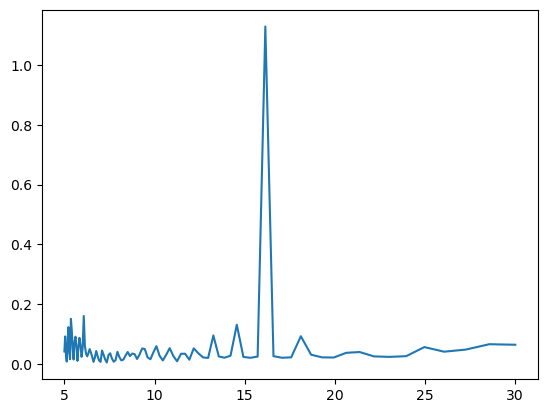

16.141304347826086


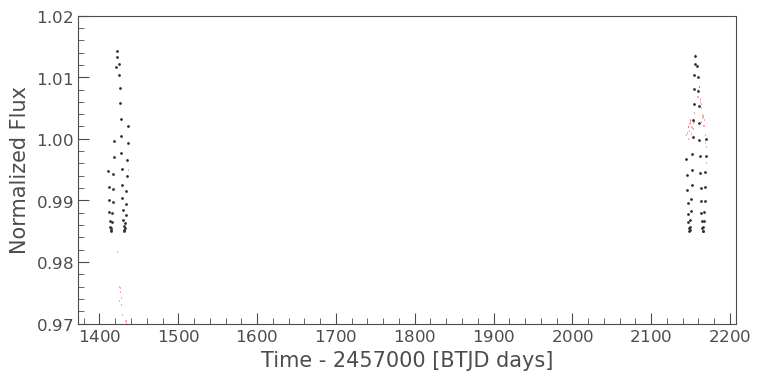

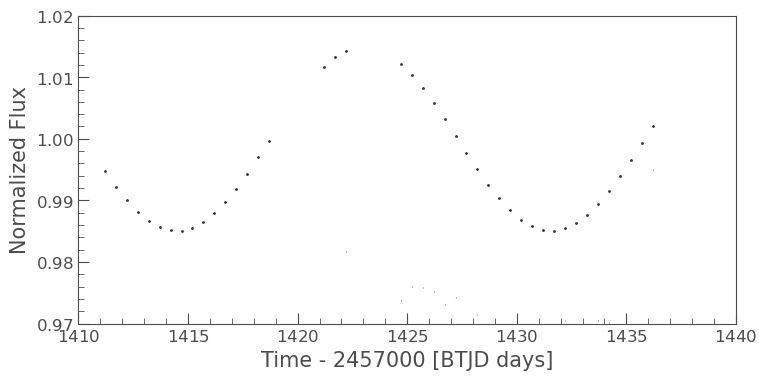

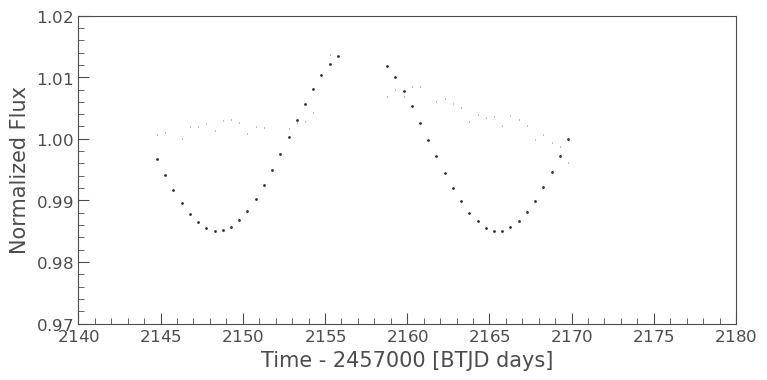

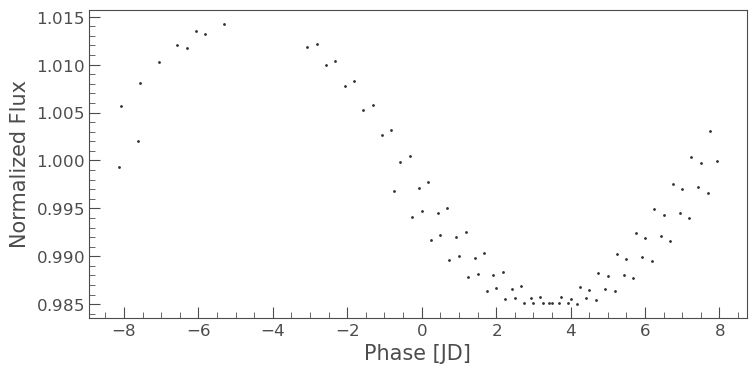

(0.0072806034432943085, 0.009152381522708851)

In [231]:
sip_kwargs = {
    "min_period": 5.0,
    "max_period": 30.0,
    "nperiods": 100,
    "bin_kwargs": {"time_bin_size": 12.0*u.hr.to("d")},
}

r = SIP(lcs, **sip_kwargs)

power_div = r["power"] / r["power_bkg"]
plt.plot(r["periods"], power_div)
plt.show()

P_max = r["periods"][np.argmax(power_div)]
print(P_max)

ax = r["corr_lc"].scatter()
r["raw_lc"].errorbar(ax=ax, color="red")
ax.set_ylim(0.97, 1.02)
plt.show()

ax = r["corr_lc"].scatter()
r["raw_lc"].errorbar(ax=ax, color="red")
ax.set_xlim(1_410, 1_440)
ax.set_ylim(0.97, 1.02)
plt.show()

ax = r["corr_lc"].scatter()
r["raw_lc"].errorbar(ax=ax, color="red")
ax.set_xlim(2_140, 2_180)
ax.set_ylim(0.97, 1.02)
plt.show()

pg = r["corr_lc"].to_periodogram(minimum_period=5, maximum_period=30)
pg.period_at_max_power
phot_phase = r["corr_lc"].remove_nans().remove_outliers(sigma=3.0).fold(pg.period_at_max_power)
ax = phot_phase.scatter()
plt.show()
f = phot_phase.flux.value
T_0 = 5_520
Delta_L = np.min(f) / np.median(f)

f_sp(T_0, 2_200, Delta_L), f_sp(T_0, 3_800, Delta_L)

In [163]:
def f_sp(T_0, T_sp, Delta_L):
    return (T_0**4 / (T_0**4 - T_sp**4)) * (1 - Delta_L)